<a href="https://colab.research.google.com/github/ridhimagarg/PyTorchBook/blob/main/Chapter03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import sys
import matplotlib.pyplot as plt


import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset


from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

# from stepbystep.vo import StepByStep ## uncomment this if working on local
from v0 import StepByStep ## this is for google drive

In [14]:
X, y = make_moons(n_samples=100, noise=0.3, random_state=0)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=13)

In [16]:
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

In [17]:
print(X)

[[ 0.03159499  0.98698776]
 [ 2.11509784 -0.04624397]
 [ 0.88248972 -0.07575606]
 [-0.0551441  -0.03733246]
 [ 0.82954503 -0.53932149]
 [ 2.11285708  0.66208353]
 [ 0.5696927   0.33744136]
 [ 0.95217454 -0.75307471]
 [-0.02922115  0.39287336]
 [ 1.71579557  0.36069454]
 [-0.27883014  0.61420539]
 [ 2.00344509 -0.3091496 ]
 [ 1.50009616 -0.74636376]
 [ 1.22540835  1.19793017]
 [ 0.46730819  0.54703192]
 [-0.36653222  1.11971633]
 [ 0.30124459  1.23315697]
 [ 0.30430746  0.82373935]
 [-0.23712492  0.77876034]
 [ 1.16339832  0.55290238]
 [-0.59702417  0.6572361 ]
 [ 0.46356735 -0.1951543 ]
 [ 0.68451111  0.75287685]
 [ 0.70515699 -0.45892444]
 [-0.65805008 -0.12944211]
 [-0.74662946 -0.3829632 ]
 [ 0.60585226  0.31252842]
 [ 2.18137168 -0.02291747]
 [ 1.91980633  0.17247329]
 [ 1.4834364  -0.10517023]
 [ 0.47404723 -0.14575067]
 [ 1.05614605 -1.03570207]
 [ 1.86500732 -0.01107874]
 [ 0.4194721  -0.32478101]
 [ 0.06873258  0.56648467]
 [-0.17332432  1.00215131]
 [ 0.12412421  1.00062892]
 

Text(0, 0.5, '$X_2$')

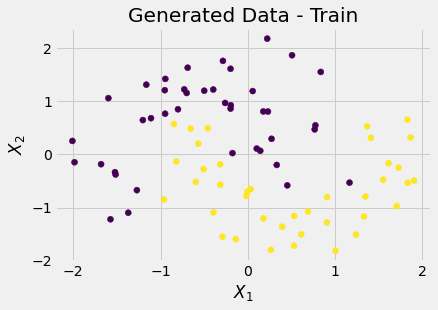

In [18]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.title("Generated Data - Train")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")

Text(0, 0.5, '$X_2$')

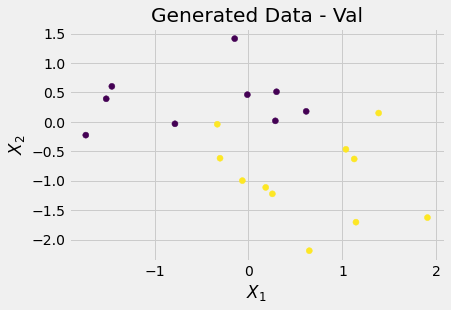

In [19]:
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val)
plt.title("Generated Data - Val")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")

## Data Preparation

In [20]:
torch.manual_seed(13)

x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1,1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1,1)).float()

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

## Model

In [21]:
torch.manual_seed(42)
model1 = nn.Sequential()
model1.add_module('linear', nn.Linear(2,1))
model1.add_module('sigmoid', nn.Sigmoid())
print(model1.state_dict())

OrderedDict([('linear.weight', tensor([[0.5406, 0.5869]])), ('linear.bias', tensor([-0.1657]))])


## Loss

In [22]:
## Work on dummy data

dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

positive_pred = dummy_predictions[dummy_labels ==1]
first_summation = torch.log(positive_pred).sum()

negative_pred = dummy_predictions[dummy_labels ==0]
second_summation = torch.log(1- negative_pred).sum()

n_total = dummy_labels.size(0)

loss = -(first_summation + second_summation) /n_total
print(loss)

tensor(0.1643)


In [23]:
## Clever way of writing the code

summation = torch.sum(
    dummy_labels * torch.log(dummy_predictions) +
    (1- dummy_labels) * torch.log(1- dummy_predictions)
)

loss = -summation /n_total
print(loss)

tensor(0.1643)


In [24]:
loss_fn = nn.BCELoss(reduction = "mean")

loss_fn

BCELoss()

In [25]:
def odds_ratio(prob):
  return prob/(1- prob)

In [26]:
def log_odds_ratio(prob):
  return np.log(odds_ratio(prob))


In [27]:
loss_fn_logits = nn.BCEWithLogitsLoss(reduction="mean")
loss_fn_logits

BCEWithLogitsLoss()

In [28]:
## dummy data

logit1 = log_odds_ratio(.9)
logit2 = log_odds_ratio(.2)

dummy_labels = torch.tensor([1.0, 0.0])
dummy_logits = torch.tensor([logit1, logit2])

print(dummy_logits)

tensor([ 2.1972, -1.3863], dtype=torch.float64)


In [29]:
loss = loss_fn_logits(dummy_logits, dummy_labels)
loss

tensor(0.1643)

### When Imbalanced data

In [30]:
## creating dummy imbalanced dataset
dummy_imb_labels = torch.tensor([1.0, 0.0, 0.0, 0.0])
dummy_imb_logits = torch.tensor([logit1, logit2, logit2, logit2])

In [31]:
## Weight calculation

n_neg = (dummy_imb_labels ==0).sum().float()
n_pos = (dummy_imb_labels ==1).sum().float()

pos_weight = (n_neg/ n_pos).view(1, )
pos_weight

tensor([3.])

In [32]:
## another loss function
loss_fn_imb = nn.BCEWithLogitsLoss(
  reduction='mean',
  pos_weight=pos_weight
)


In [33]:
loss = loss_fn_imb(dummy_imb_logits, dummy_imb_labels)
loss
## But its different, what we want is this -:


tensor(0.2464)

In [34]:
## As pytorch by deafult doesnt handle it, we have to do it this way.
loss_fn_imb_sum = nn.BCEWithLogitsLoss(
  reduction='sum',
  pos_weight=pos_weight
)
loss = loss_fn_imb_sum(dummy_imb_logits, dummy_imb_labels)
loss = loss / (pos_weight * n_pos + n_neg)
loss


tensor([0.1643])

## Model Configuration with BCE Loss

In [35]:
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2,1))

optimizer = optim.SGD(model.parameters(), lr=lr)

loss_fn = nn.BCEWithLogitsLoss()

## Model Training

In [36]:
n_epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader ,val_loader)
sbs.train(n_epochs)

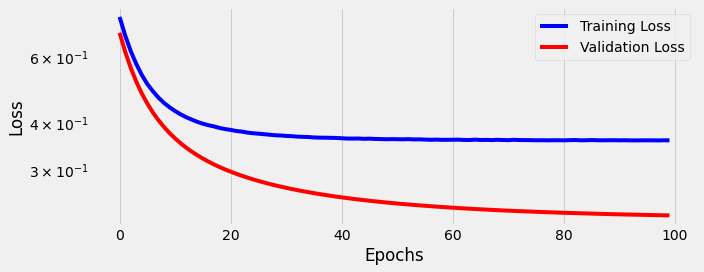

In [37]:
fig = sbs.plot_losses()

In [38]:
predictions = sbs.predict(x_train_tensor[:4])
predictions

array([[ 0.20345592],
       [ 2.9444451 ],
       [ 3.6933177 ],
       [-1.2334073 ]], dtype=float32)

In [39]:
## We can make classification using predictions

classes = (predictions>=0).astype(np.int)
classes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


array([[1],
       [1],
       [1],
       [0]])

In [41]:
def split_cm(cm):
  # Actual negatives go in the top row,
  # above the probability line
  actual_negative = cm[0]
  # Predicted negatives go in the first column
  tn = actual_negative[0]
  # Predicted positives go in the second column
  fp = actual_negative[1]
  # Actual positives go in the bottow row,
  # below the probability line
  actual_positive = cm[1]
  # Predicted negatives go in the first column
  fn = actual_positive[0]
  # Predicted positives go in the second column
  tp = actual_positive[1]
  return tn, fp, fn, tp


In [40]:
def precision_recall(cm):
  tn, fp, fn, tp = split_cm(cm)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  return precision, recall
